In [1]:
#6000 TRAIN, 4000 TEST
#no signal (0) BLUE , electron/positron (1) GREEN , another kind of particles (2) YELLOW

import csv
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn.model_selection
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from mpl_toolkits.mplot3d import Axes3D
import tables

from tqdm import trange

train_file = '/u/gl/tedeschi/phase1/dataset/train_1-2.hdf5'
#test_file = '/~/phase1/dataset/test_1-2.hdf5'
#submission_file = 'submission_1-2.hdf5'

f=tables.open_file(train_file, 'r')

In [2]:
def read_events(start_index=0, end_index=100):
    X_train, y_train, w_train = [], [], []
    for event_index in trange(start_index, end_index):
        data_hits = np.array(f.root.data[event_index : event_index + 1])
        data_labels=np.array(f.root.label[event_index : event_index + 1],dtype=np.int64)
        data_weights = np.zeros([1,192,192,192],dtype=np.float32)
        vals, counts = np.unique(data_labels,return_counts=True)
        for i, val in enumerate(vals):
            if val==0:
                data_weights[np.where(data_labels == val)] = 0.
            else:
                data_weights[np.where(data_labels == val)] = 1. / counts[i] / len(vals)
        X_train.append(data_hits)
        y_train.append(data_labels)
        w_train.append(data_weights)
    return np.concatenate(X_train), np.concatenate(y_train), np.concatenate(w_train)


In [3]:
from IPython.display import HTML, display
import commands,sys,os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.python.platform
import tensorflow.contrib.layers as L
import tensorflow.contrib.slim as slim
IMAGE_SIZE=192

In [4]:
def imshow_test(num_images,X,y,w):
    images_plot, labels_plot, weights_plot, preds_plot, probs_plot = sess.run([images, labels, weights, prediction, softmax], feed_dict={images: X,
                                                                                                                                         labels: y,
                                                                                                                                         weights: w})
    
    if num_images is None or num_images > len(images_plot):
        num_images = len(images_plot)
    
    for index in range(num_images):
        print "ENERGY DEPOSITION"
        fig=plt.figure()
        crop=images_plot[index].reshape([IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE])
        ax = fig.add_subplot(111,projection='3d')
        x,y,z = np.where(crop>0)
        v=crop[crop>0]
        cv = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=40)
        plt.colorbar(cv)
        plt.show()
    
        print "LABELS"
        fig=plt.figure()
        data_labels=labels_plot[index].reshape([IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE])
        ax = fig.add_subplot(111,projection='3d')
        x,y,z = np.where(crop>0)
        v=data_labels[crop>0]
        cl = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=2)
        plt.colorbar(cl)
        plt.show()
        print np.unique(data_labels,return_counts=True)
        
        print "WEIGHTS"
        fig=plt.figure()
        data_labels=weights_plot[index].reshape([IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE])
        ax = fig.add_subplot(111,projection='3d')
        x,y,z = np.where(crop>0)
        v=data_labels[crop>0]
        cl = ax.scatter(x,y,z,c=v, marker='o', vmin=1e-4,vmax=1e-3)
        plt.colorbar(cl)
        plt.show()
        print np.unique(data_labels,return_counts=True)
        
        print "PREDICTION"
        fig=plt.figure()
        data_labels=preds_plot[index].reshape([IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE])
        ax = fig.add_subplot(111,projection='3d')
        x,y,z = np.where(crop>0)
        v=data_labels[crop>0]
        cl = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=2)
        plt.colorbar(cl)
        plt.show()
        print np.unique(data_labels,return_counts=True)
        

In [5]:
with tf.variable_scope("input"):
    images  = tf.placeholder(tf.float32, [None, 192, 192, 192])
    labels  = tf.placeholder(tf.int64,   [None, 192, 192, 192])
    weights = tf.placeholder(tf.float32, [None, 192, 192, 192])
    images3D = tf.reshape(images, [-1, 192, 192, 192, 1])

In [6]:
def toy_resnet_module(input_tensor, num_outputs, trainable=True, kernel=(3,3,3), stride=1, scope='noscope'):

    fn_conv = slim.conv3d

    num_inputs  = input_tensor.get_shape()[-1].value
    with tf.variable_scope(scope):
        shortcut = None
        if num_outputs == num_inputs and stride ==1 :
            shortcut = input_tensor
        else:
            shortcut = slim.conv3d(inputs      = input_tensor,
                                   num_outputs = num_outputs,
                                   kernel_size = 1,
                                   stride      = stride,
                                   normalizer_fn = slim.batch_norm,
                                   activation_fn = None,
                                   trainable   = trainable,
                                   scope       = 'shortcut')
        residual = slim.conv3d(inputs      = input_tensor,
                               num_outputs = num_outputs,
                               kernel_size = kernel,
                               stride      = stride,
                               normalizer_fn = slim.batch_norm,
                               #activation_fn = None,
                               trainable   = trainable,
                               scope       = 'resnet_conv1')
        
        residual = slim.conv3d(inputs      = residual,
                               num_outputs = num_outputs,
                               kernel_size = kernel,
                               normalizer_fn = slim.batch_norm,
                               activation_fn = None,
                               trainable   = trainable,
                               scope       = 'resnet_conv2')
        
        return tf.nn.relu(shortcut + residual)

def double_toy_resnet(input_tensor, num_outputs, trainable=True, kernel=3, stride=1, scope='noscope'):

    with tf.variable_scope(scope):

        resnet1 = toy_resnet_module(input_tensor=input_tensor,
                                    trainable=trainable,
                                    kernel=kernel,
                                    stride=stride,
                                    num_outputs=num_outputs,
                                    scope='module1')
        
        resnet2 = toy_resnet_module(input_tensor=resnet1,
                                    trainable=trainable,
                                    kernel=kernel,
                                    stride=1,
                                    num_outputs=num_outputs,
                                    scope='module2')

        return resnet2

def toy_uresnet(input_tensor, num_class, reuse=False, trainable=True, base_filter=16, num_contraction=4):

    with tf.variable_scope('toy_uresnet', reuse=reuse):
    
        conv_feature_map={}
        net = input_tensor
        print('Input shape {:s}'.format(net.shape))

        # 1st conv layer normal
        net = slim.conv3d     (net, base_filter, 3, normalizer_fn=slim.batch_norm, trainable=trainable, scope='conv0')
        conv_feature_map[net.get_shape()[-1].value] = net
        print('Encoding step 0 shape {:s}'.format(net.shape))  

        net = slim.max_pool3d (net,              2, scope='maxpool0')    
        # encoding steps
        for step in range(num_contraction):
            num_outputs = base_filter * (2**(step+1))
            stride = 2
            if step == 0: stride = 1
            net = double_toy_resnet(net, num_outputs, trainable=trainable, stride=stride, scope='res{:d}'.format(step+1))
            conv_feature_map[net.get_shape()[-1].value] = net
            print('Encoding step {:d} shape {:s}'.format(step+1,net.shape))
        # decoding steps
        for step in range(num_contraction):
            num_outputs = net.get_shape()[-1].value / 2
            net = slim.conv3d_transpose(net, num_outputs, 3, stride=2, normalizer_fn=slim.batch_norm, trainable=trainable, scope='deconv{:d}'.format(step))
            net = tf.concat([net, conv_feature_map[num_outputs]], axis=len(net.shape)-1, name='concat{:d}'.format(step))
            net = double_toy_resnet(net, num_outputs, trainable=trainable, scope='conv{:d}'.format(step+num_contraction+1))
            print('Decoding {:d} shape {:s}'.format(step,net.shape))

        # final conv layer
        net = slim.conv3d(net, num_class, 3, normalizer_fn=slim.batch_norm, trainable=trainable, scope='lastconv')
        print('Final shape {:s}'.format(net.shape))  
        return net
 

In [7]:
print('Building train net...')
train_net = toy_uresnet (images3D, 3, trainable=True,  reuse=False, base_filter=8, num_contraction=4)

print('\nBuilding test net...')
test_net  = toy_uresnet (images3D,  3, trainable=False, reuse=True, base_filter=8, num_contraction=4)

Building train net...
Input shape (?, 192, 192, 192, 1)
Encoding step 0 shape (?, 192, 192, 192, 8)
Encoding step 1 shape (?, 96, 96, 96, 16)
Encoding step 2 shape (?, 48, 48, 48, 32)
Encoding step 3 shape (?, 24, 24, 24, 64)
Encoding step 4 shape (?, 12, 12, 12, 128)
Decoding 0 shape (?, 24, 24, 24, 64)
Decoding 1 shape (?, 48, 48, 48, 32)
Decoding 2 shape (?, 96, 96, 96, 16)
Decoding 3 shape (?, 192, 192, 192, 8)
Final shape (?, 192, 192, 192, 3)

Building test net...
Input shape (?, 192, 192, 192, 1)
Encoding step 0 shape (?, 192, 192, 192, 8)
Encoding step 1 shape (?, 96, 96, 96, 16)
Encoding step 2 shape (?, 48, 48, 48, 32)
Encoding step 3 shape (?, 24, 24, 24, 64)
Encoding step 4 shape (?, 12, 12, 12, 128)
Decoding 0 shape (?, 24, 24, 24, 64)
Decoding 1 shape (?, 48, 48, 48, 32)
Decoding 2 shape (?, 96, 96, 96, 16)
Decoding 3 shape (?, 192, 192, 192, 8)
Final shape (?, 192, 192, 192, 3)


In [8]:
with tf.variable_scope('analysis'):
    prediction     = tf.argmax(test_net,4)
    accuracy_allpx = tf.reduce_mean(tf.cast(tf.equal(prediction, labels),tf.float32))
    nonzero_idx    = tf.where(tf.reshape(images, [-1, 192, 192, 192]) > tf.to_float(0.) )
    nonzero_label  = tf.gather_nd(labels, nonzero_idx)
    nonzero_pred   = tf.gather_nd(tf.argmax(test_net, 4), nonzero_idx)
    accuracy_valpx = tf.reduce_mean(tf.cast(tf.equal(nonzero_label, nonzero_pred),tf.float32))
    softmax        = tf.nn.softmax(logits=test_net)
    
    nonzero_softmax = tf.gather_nd(softmax,nonzero_idx)
    

print np.shape(test_net)
print np.shape(prediction)
print np.shape(labels)
print np.shape(nonzero_label)
print np.shape(softmax)
print np.shape(nonzero_softmax)
with tf.variable_scope('train'):
    loss_pixel     = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=train_net)
    loss_weighted  = tf.multiply(loss_pixel, weights)
    loss           = tf.reduce_mean(tf.reduce_sum(tf.reshape(loss_weighted, [-1, int(192**3)]),axis=1))
    learning_rate  = tf.placeholder(tf.float32,[])
    train          = tf.train.AdamOptimizer(learning_rate).minimize(loss)

(?, 192, 192, 192, 3)
(?, 192, 192, 192)
(?, 192, 192, 192)
(?,)
(?, 192, 192, 192, 3)
(?, 3)


In [12]:
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())
#reader = tf.train.Saver(tf.get_collection(tf.GraphKeys.MODEL_VARIABLES))

#for j in range(13,18):
 #   reader.restore(sess, './9-05-1_zero_weights-'+str(j*1000))

 #   fout=open('9-05-1_zero_weights-{}.csv'.format(j*1000),'w')
 #   fout.write('entry,accuracy\n')
 #   for i in range(2):
 #       X_train, y_train, w_train = read_events(start_index=i, end_index=i+1)
        #print('test accuracy on non-zero pixels%g' % sess.run(accuracy_valpx, feed_dict={images: X_train, labels: y_train, weights: w_train}))
 #       acc,soft=sess.run([accuracy_valpx,nonzero_softmax], feed_dict={images: X_train, labels: y_train, weights: w_train})
        
        #accuracy[i]=acc
        #fout.write('entry,accuracy\n')
 #       entry = i
 #       accuracy = float(acc)
  #      fout.write('%d,%g' % (entry,accuracy))
  #      fout.write('\n')
  #  fout.close()
    #imshow_test(16,X_train,y_train,w_train)
    #print np.mean(accuracy)
    
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())
reader = tf.train.Saver(tf.get_collection(tf.GraphKeys.MODEL_VARIABLES))

for j in range(13,18):
    reader.restore(sess, '/u/gl/tedeschi/phase1/9-05-1_zero_weights-'+str(j*1000))

    fout=open('9-05-1_zero_weights-{}.csv'.format(j*1000),'w')
    fout.write('entry,accuracy,softmax\n')
    for i in range(2):
        X_train, y_train, w_train = read_events(start_index=i, end_index=i+1)
        #print('test accuracy on non-zero pixels%g' % sess.run(accuracy_valpx, feed_dict={images: X_train, labels: y_train, weights: w_train}))
        
        acc,soft,nonzero_idxx=sess.run([accuracy_valpx,softmax,nonzero_idx], feed_dict={images: X_train, labels: y_train, weights: w_train})
        result = np.zeros(y_train.shape,dtype=np.float32)
        #print np.shape(result)
        #print np.shape(soft)
        for class_label in range(1,3):
            class_mask = np.where(y_train==class_label)
            result[class_mask] = (soft[:,:,:,:,class_label])[class_mask] 
        
        print np.shape(X_train)
        #nonzero_idxx=np.where(X_train > 0.)
        #print np.shape(result)
        print np.shape(nonzero_idxx)
        result=np.take(result,nonzero_idxx)
        #accuracy[i]=acc
        #fout.write('entry,accuracy\n')
        entry = i
        accuracy = float(acc)
        s = result.mean()
        fout.write('%d,%g,%g' % (entry,accuracy,s))
        fout.write('\n')
    fout.close()
    #imshow_test(16,X_train,y_train,w_train)
    #print np.mean(accuracy)




    


INFO:tensorflow:Restoring parameters from /u/gl/tedeschi/phase1/9-05-1_zero_weights-13000


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 192, 192, 192)
(1099, 4)


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


(1, 192, 192, 192)
(1014, 4)
INFO:tensorflow:Restoring parameters from /u/gl/tedeschi/phase1/9-05-1_zero_weights-14000


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 192, 192, 192)
(1099, 4)


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


(1, 192, 192, 192)
(1014, 4)
INFO:tensorflow:Restoring parameters from /u/gl/tedeschi/phase1/9-05-1_zero_weights-15000


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 192, 192, 192)
(1099, 4)


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


(1, 192, 192, 192)
(1014, 4)
INFO:tensorflow:Restoring parameters from /u/gl/tedeschi/phase1/9-05-1_zero_weights-16000


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 192, 192, 192)
(1099, 4)


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


(1, 192, 192, 192)
(1014, 4)
INFO:tensorflow:Restoring parameters from /u/gl/tedeschi/phase1/9-05-1_zero_weights-17000


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 192, 192, 192)
(1099, 4)


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


(1, 192, 192, 192)
(1014, 4)


In [13]:
import pandas as pd
import sys

ac=np.zeros(5)
so=np.zeros(5)
for j in range(13,18):

    df = pd.read_csv('9-05-1_zero_weights-{}.csv'.format(j*1000),dtype={'accuracy': float})

    for x in range(df.entry.size):
        print 'entry',df.entry.values[x],'accuracy',df.accuracy.values[x], 'softmax', df.softmax.values[x]
    print
    ac[j-13]=df.accuracy.values.mean()
    so[j-13]=df.softmax.values.mean()
    
    print 'Mean accuracy', df.accuracy.values.mean()
    print 'Mean Softmax', df.softmax.values.mean()
    print

entry 0 accuracy 0.9208370000000001 softmax 0
entry 1 accuracy 0.9270219999999999 softmax 0

Mean accuracy 0.9239295000000001
Mean Softmax 0.0

entry 0 accuracy 0.938126 softmax 0
entry 1 accuracy 0.977318 softmax 0

Mean accuracy 0.957722
Mean Softmax 0.0

entry 0 accuracy 0.939945 softmax 0
entry 1 accuracy 0.9497040000000001 softmax 0

Mean accuracy 0.9448245000000001
Mean Softmax 0.0

entry 0 accuracy 0.938126 softmax 0
entry 1 accuracy 0.935897 softmax 0

Mean accuracy 0.9370115
Mean Softmax 0.0

entry 0 accuracy 0.9390350000000001 softmax 0
entry 1 accuracy 0.897436 softmax 0

Mean accuracy 0.9182355
Mean Softmax 0.0



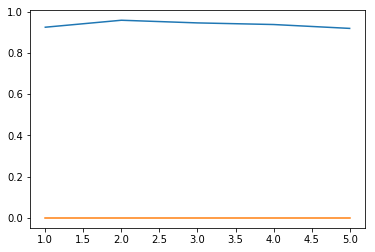

In [14]:
#fig,ax1=plt.subplots(figsize=(12,8),facecolor='w')
#ax1.plot(np.arange(0,5,ac,linewidth=2,label='Loss',color='b')
#ax1.set_xlabel('Iterations',fontweight='bold',fontsize=24,color='black')
#ax1.tick_params('x',colors='black',labelsize=18)
#ax1.set_ylabel('Non-zero pixel accuracy', fontsize=24, fontweight='bold',color='b')
#ax1.tick_params('y',colors='b',labelsize=18)

#ax2 = ax1.twinx()
#ax2.plot(0,5,so,color='r',label='Softmax')
#ax2.set_ylabel('Softmax', fontsize=24, fontweight='bold',color='r')
#ax2.tick_params('y',colors='r',labelsize=18)
#ax2.set_ylim(0.,0.2)

#plt.grid()
#plt.show()

plt.plot([1,2,3,4,5],ac)
plt.plot([1,2,3,4,5],so)